# Calibración de una Cámara con OpenCV
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/2-Percepcion/2-1-Calibracion-Camara.ipynb)

Nota: si se utiliza Google Colab, la función `cv2.imshow` no funciona. En este caso algunas alternativas son:
* Usar `from google.colab.patches import cv2_imshow` y mostrar la imagen con `cv2_imshow(Imagen)`
* De `matplotlib.pyplot`, usar `plt.imshow` para mostrar las imágenes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt   # Para mostrar las imágenes
import glob                       # Para importar los nombres de las imágenes

# Importar OpenCV
import cv2

# Para google colab
from google.colab.patches import cv2_imshow

In [2]:
# Indicación sobre si se utiliza o no colab
colab = True

Si se usa Google Colab: descargar las imágenes (zip) y descomprimirlas. Si no se usa, se debe tener una carpeta local llamada `imagenes` donde se encuentren las imágenes.

In [3]:
if colab:
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/2-Percepcion/imagenes.zip
    !unzip -qq imagenes.zip -d imagenes

In [4]:
# Lista de los nombres de las imágenes usadas para la calibración
image_names = glob.glob('imagenes/tablero*.jpg')
print(image_names)

['imagenes/tablero15.jpg', 'imagenes/tablero17.jpg', 'imagenes/tablero18.jpg', 'imagenes/tablero03.jpg', 'imagenes/tablero09.jpg', 'imagenes/tablero27.jpg', 'imagenes/tablero14.jpg', 'imagenes/tablero26.jpg', 'imagenes/tablero08.jpg', 'imagenes/tablero11.jpg', 'imagenes/tablero06.jpg', 'imagenes/tablero01.jpg', 'imagenes/tablero10.jpg', 'imagenes/tablero22.jpg', 'imagenes/tablero07.jpg', 'imagenes/tablero21.jpg', 'imagenes/tablero13.jpg', 'imagenes/tablero05.jpg', 'imagenes/tablero16.jpg', 'imagenes/tablero04.jpg', 'imagenes/tablero24.jpg', 'imagenes/tablero20.jpg', 'imagenes/tablero23.jpg', 'imagenes/tablero02.jpg', 'imagenes/tablero19.jpg', 'imagenes/tablero25.jpg', 'imagenes/tablero12.jpg']


## 1. Puntos en el objeto (índices)

La imagen (patrón) de calibración utilizada para adquirir las imágenes con la cámara que se desea calibrar se muestra a continuación. 

<img src="https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/2-Percepcion/imagenes/patronReal.jpg" width="400" height="400">

Para la calibración en OpenCV son importantes solamente los puntos que determinan las intersecciones internas; es decir, aquellos puntos rodeados por dos cuadrados negros y dos cuadrados blancos. Se puede determinar que hay 8 intersecciones internas en la horizontal (eje $X$), y 6 puntos en la vertical (eye $Y$), dando un total de 48 intersecciones. A estos puntos se les denomina "puntos del objeto" ("object points") y cada uno se representará como $(X_i,Y_i,0)$, donde $X_i$, $Y_i$ son enteros que comienzan en cero. Así, a la primera intersección se le asociará el punto $(0,0,0)$, a la segunda $(1,0,0)$, y así hasta llegar al último punto $(7,5,0)$.

In [5]:
# Preparar los puntos del objeto: (0,0,0), (1,0,0), (2,0,0) ..., (7,5,0)
nx = 8; ny = 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(nx*ny,2)

print("Primeros puntos:"); print(objp[0:3])
print("Últimos puntos:"); print(objp[-4:])

Primeros puntos:
[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]]
Últimos puntos:
[[4. 5. 0.]
 [5. 5. 0.]
 [6. 5. 0.]
 [7. 5. 0.]]


## 2. Puntos en la imagen (corners)

A continuación se muestra un ejemplo de cómo obtener los puntos correspondientes a las intersecciones internas del patrón en la imagen (llamados "corners") para una única imagen. Con este fin se utiliza la función [`findChessboardCorners`](https://docs.opencv.org/3.4.8/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a).

Tamaño de la imagen: (x,y)=(400,300)


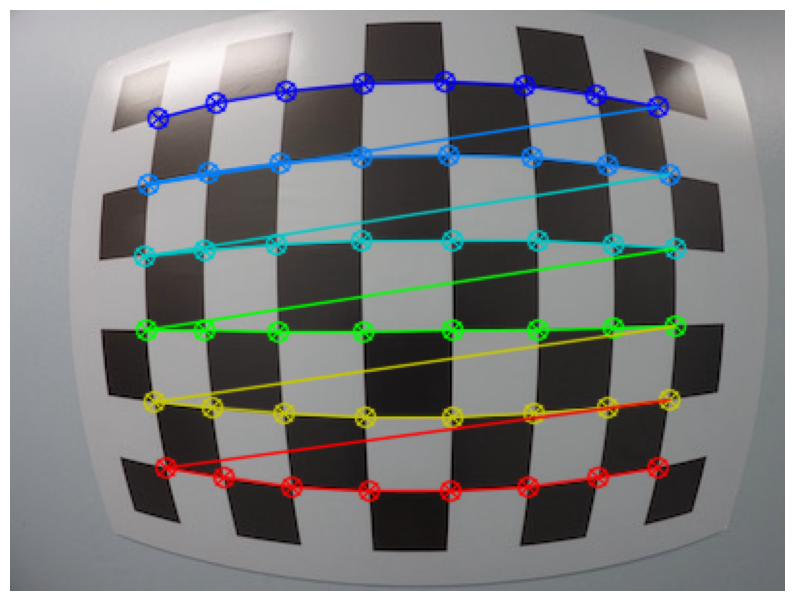

In [6]:
# Lectura de una imagen
I = cv2.imread(image_names[23])
# Tamaño de la imagen
I_size = (I.shape[1], I.shape[0])
print("Tamaño de la imagen: (x,y)=({},{})".format(I_size[0], I_size[1]))
# Conversión de la imagen a escala de grises
Igray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

# Encontrar las esquinas (corners) internas del patrón. A estas esquinas se les denomina también 
# "puntos de la imagen" ("image points")
retval, corners = cv2.findChessboardCorners(Igray, (nx, ny), None)

# Si se encuentra los puntos (corners), mostrar la imagen con los puntos
if retval == True:
    # Añadir los puntos (corners) encontrados a la imagen
    cv2.drawChessboardCorners(I, (8,6), corners, retval)
    # Mostrar la imagen
    plt.figure(figsize=(10,10))
    plt.imshow(I, cmap='gray')
    plt.axis('off')
    plt.show()

Se encontrará las esquinas en todas las imágenes usando [`findChessboardCorners`](https://docs.opencv.org/3.4.8/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a) y se agregará las coordenadas de las esquinas (en píxeles) a la lista `img_points`. Correspondientemente, se agregará las coordenadas (índices) de los puntos en el objeto a la lista `obj_points`.

In [ ]:
# Listas que almacenan los puntos del objeto (índices) y los puntos de la imagen (corners)
# para todas las imágenes
obj_points = []     # Puntos del objeto (3d)
img_points = []     # Puntos de la imagen (2d)

# Bucle a lo largo de todas las imágenes, buscando las "esquinas" (corners)
for idx, iname in enumerate(image_names):
    # Leer la imagen
    I = cv2.imread(iname)
    # Convertir a escala de grises
    Igray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    # Encontrar las esquinas (corners) internas del patrón
    retval, corners = cv2.findChessboardCorners(Igray, (nx,ny), None)

    # Si se encuentra los puntos, añadirlos a la lista
    if retval == True:
        # Puntos del objeto y puntos de la imagen, para la imagen actual
        obj_points.append(objp)
        img_points.append(corners)

        # Añadir a la imagen los puntos (corners) encontrados
        cv2.drawChessboardCorners(I, (8,6), corners, retval)
        
        # Si se desea grabar las imágenes con sus "corners", descomentar la siguiente línea
        # cv2.imwrite('corners'+str(idx)+'.jpg', I)
        
        # Mostrar la imagen (se puede abrir una ventana adicional)
        if colab:
            cv2_imshow(I)
        else:    
            cv2.imshow('Imagen con puntos esquina', I)
            cv2.waitKey(500)

if not colab:
    cv2.destroyAllWindows()

## 3. Calibración de la Cámara

La calibración de la cámara se realiza usando la función [`calibrateCamera`](https://docs.opencv.org/3.4.8/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d), teniendo como entrada los puntos del objeto `obj_points`, los puntos correspondientes en la imagen `img_points`, y el tamaño de las imágenes.

In [13]:
# Calibración de la cámara dados los puntos objeto (3D) y los puntos imágen (corners) correspondientes
retval, M, coefs_dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, I_size, None, None)

In [14]:
# Mostrar los los parámetros
print("Matriz de calibración:"); print(np.round(M,3))
print("\nCoeficientes de distorsión:"); print(np.round(coefs_dist,3))

Matriz de calibración:
[[174.786   0.    203.069]
 [  0.    175.149 155.515]
 [  0.      0.      1.   ]]

Coeficientes de distorsión:
[[-0.232  0.061 -0.     0.    -0.007]]


Los parámetros pueden ser almacenados en un archivo binario, usando la biblioteca llamada `pickle`, para luego ser cargados cuando sea necesario. Los parámetros calibrados se almacenarán en formato de diccionario (pero en binario) en el archivo `camera_params.p`.

In [15]:
# Grabar los valores usando pickle
import pickle

# Estructura para almacenar parámetros calibrados
dist_pickle = {}
dist_pickle["M"] = M
dist_pickle["coefs_dist"] = coefs_dist

# Almacenar los parámetros de la cámara
pickle.dump(dist_pickle, open("camera_params.p", "wb"))

Para quitar la distorsión a una imagen, se puede cargar la imagen y luego aplicar la función [undistort](https://docs.opencv.org/3.4.8/da/d54/group__imgproc__transform.html#ga69f2545a8b62a6b0fc2ee060dc30559d).

## 4. Aplicación de la Calibración a una Imagen

Los parámetros intrínsecos obtenidos durante la calibración de la cámara pueden ser obtenidos para quitar la distorsión a una imagen. Con este fin se utiliza la función `cv2.undistort`.

In [16]:
# Si se usa colab, descargar la imagen de prueba 2
if colab:
    !wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/2-Percepcion/imagenes_prueba/imagen2.jpg

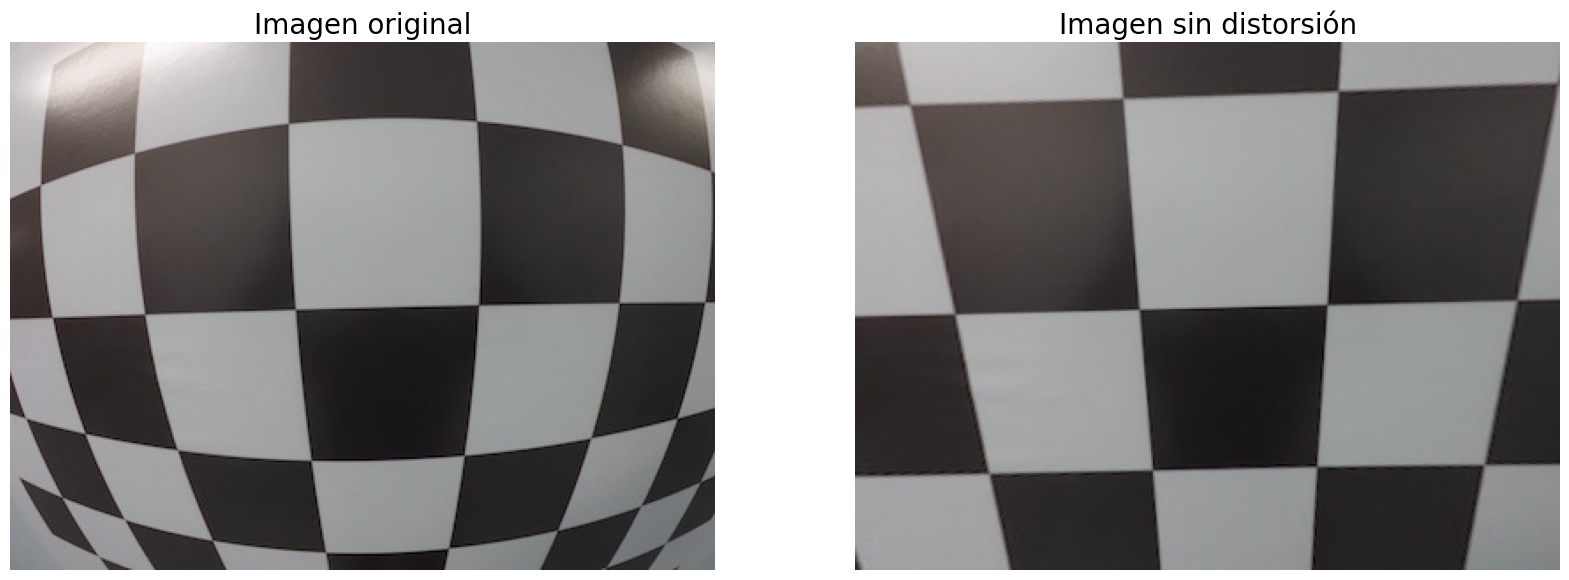

In [17]:
# Imagen de entrada
Iorig = cv2.imread('imagen2.jpg')

# Corregir la distorsión
Iundist = cv2.undistort(Iorig, M, coefs_dist, None)

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(Iorig)
ax1.set_title('Imagen original', fontsize=20); ax1.axis('off')
ax2.imshow(Iundist)
ax2.set_title('Imagen sin distorsión', fontsize=20); ax2.axis('off');